# Applying PCA for the feature selection
# Table of contents

1. [PCA](#pca)    
2. [Training and test](#training)    
2. [Validation](#validation)    
    1. [Confusion matrices](#confusion)    
    2. [ROC](#roc_val)    
    3. [Error metrics](#error)    
    4. [Spearman correlation](#spearman)    
    5. [Distribution of the data](#distribution)     

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the data
training = pd.read_csv('../training_set.csv.gz', compression='gzip')
validation = pd.read_csv('../validation_set.csv.gz', compression='gzip')

In [3]:
descriptors_list = training.columns.tolist()[2:]

<a id='pca'></a>
## PCA

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()

In [6]:
# Split training set into X and y
y_training = training['activity']
X_training = training[descriptors_list].copy()

# Apply StandardScaler on X
X_transformed = scaler.fit_transform(X_training)
X_training = pd.DataFrame(X_transformed, columns=X_training.columns.tolist())

In [7]:
# Fit and transform the training data
pca = PCA(n_components=0.90)
X_training_pca = pca.fit_transform(X_training)

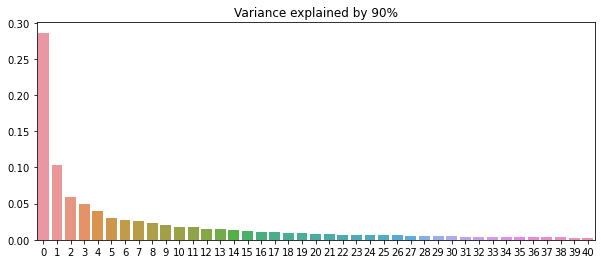

In [8]:
plt.figure(figsize=(10,4))
sns.barplot(x=[i for i in range(pca.n_components_)], y=pca.explained_variance_ratio_)
plt.title(f'Variance explained by {sum(pca.explained_variance_ratio_) * 100:.0f}%')
plt.savefig('pca_variance.png', dpi=200)

In [9]:
training_pca = pd.DataFrame(X_training_pca)
training_pca.columns = [f'PCA_{i:02d}' for i in range(1, pca.n_components_ + 1)]
training_pca['CID'] = training['CID'].tolist()
training_pca['activity'] = y_training.tolist()

In [10]:
# Rearrange the columns
cols = training_pca.columns.tolist()
cols = cols[-2:] + cols[:-2]
training_pca = training_pca[cols]
features = training_pca.columns.tolist()[2:]

training_pca.head()

,CID,activity,PCA_01,PCA_02,PCA_03,PCA_04,PCA_05,PCA_06,PCA_07,PCA_08,...,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41
0,JAG-UCB-4709a583-1,0,-5.454930,10.823066,-2.204217,-7.422635,-2.299849,1.822709,8.134413,-4.078203,...,0.862028,-1.468531,-1.973744,0.390512,0.784341,-2.634041,0.643692,-0.204657,1.707754,-1.575873
1,LON-WEI-b8d98729-9,0,20.144187,12.603972,-11.553649,-1.735662,-15.070931,-7.173012,-3.851642,1.098487,...,0.659196,1.487766,-0.363106,0.838426,-0.226937,-3.499894,-2.854649,-0.973601,-3.398272,-0.786062
2,MAT-POS-916a2c5a-2,1,1.179978,6.019681,-1.570128,-17.265170,8.656782,5.767030,-3.364130,6.747628,...,1.803561,-0.385591,2.562942,-2.146445,2.373015,1.052142,-1.028695,0.839362,-0.268753,-1.137629
3,ERI-BAS-37e2bb46-1,0,13.633177,5.859002,-2.789909,-11.044010,-1.123366,-4.761020,13.033583,-3.872354,...,0.186313,1.420638,1.325503,-1.415296,-5.579805,2.936048,-1.573876,-4.237600,1.925906,3.507722
4,LON-WEI-adc59df6-1,0,30.534185,-9.696926,0.666985,6.563478,3.101732,0.979461,-1.983570,0.418521,...,-0.844795,0.287817,-1.676340,1.780747,0.073632,1.795886,1.198452,-1.743120,1.840566,-2.698338


In [11]:
y_val = validation['activity']
X_val = validation[descriptors_list].copy()
X_transformed = scaler.transform(X_val)
X_val = pd.DataFrame(X_transformed, columns=X_val.columns.tolist())

In [12]:
# Transform the validation data
X_val_pca = pca.transform(X_val)

In [13]:
validation_pca = pd.DataFrame(X_val_pca)
validation_pca.columns = [f'PCA_{i:02d}' for i in range(1, pca.n_components_ + 1)]
validation_pca['CID'] = validation['CID'].tolist()
validation_pca['activity'] = y_val.tolist()

In [14]:
# Rearrange the columns
cols = validation_pca.columns.tolist()
cols = cols[-2:] + cols[:-2]
validation_pca = validation_pca[cols]

validation_pca.head()

,CID,activity,PCA_01,PCA_02,PCA_03,PCA_04,PCA_05,PCA_06,PCA_07,PCA_08,...,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41
0,LON-WEI-4d77710c-4,0,11.448072,1.621623,-7.109270,3.324717,-6.913497,6.532565,0.391615,7.833608,...,-2.446296,-1.192112,-1.670141,1.875104,0.146601,-0.392450,-2.892121,-0.326191,-1.873303,2.848464
1,LON-WEI-4d77710c-8,1,24.180516,24.941733,17.355960,4.748625,1.608133,-1.830816,15.405395,14.320233,...,4.917365,-1.270023,-1.402758,2.233088,-0.618244,0.116228,0.214068,3.171501,0.448223,4.498359
2,LON-WEI-4d77710c-41,0,19.224185,23.044386,11.480320,3.707445,-9.828768,-4.877247,8.651140,-1.140723,...,-1.183410,-5.184090,-0.242065,7.160700,-4.064296,-2.733568,1.177007,-3.022539,4.857068,0.667125
3,LON-WEI-4d77710c-51,1,13.946055,-4.045107,0.957812,-1.891182,2.199729,7.528260,5.983936,-2.206985,...,-0.878563,-2.938733,-1.063158,0.240390,-0.939251,-1.178433,-0.145819,-1.886128,0.215614,2.498305
4,LON-WEI-4d77710c-70,1,-23.995763,8.256701,-5.303832,0.370383,-13.542907,14.059471,13.523411,-4.850814,...,0.125347,0.868347,-3.518942,-3.080950,1.188779,0.127566,0.029053,1.457508,-0.614844,0.484986


<a id='training'></a>
## Training and test

In [15]:
def get_model_by_name(model_name):
    if model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=500, max_depth=6, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=13)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='binary:logistic', n_estimators=200, 
            max_depth=5, eta=0.01, random_state=13)
    elif model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV applies probability transformation 
        # on top of the SVC outputs, so we can plot its ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    
    
def train_test_scores(X_train, X_test, y_train, y_test, pipe):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from imblearn.metrics import geometric_mean_score
    
    scores = []
    
    y_pred = pipe.predict(X_test)
    scores.append(f1_score(y_test, y_pred))              # test_f1
    scores.append(geometric_mean_score(y_test, y_pred))  # test_geometric_mean
    
    y_proba = pipe.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test, y_proba))        # test_roc_auc
    
    y_pred = pipe.predict(X_train)
    scores.append(f1_score(y_train, y_pred))             # train_f1
    scores.append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
    
    y_proba = pipe.predict_proba(X_train)[:,1]
    scores.append(roc_auc_score(y_train, y_proba))       # train_roc_auc
    
    return scores


def feature_transformer(X):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import OneHotEncoder

    return ColumnTransformer(transformers=[
        ('continuous', StandardScaler(), X.select_dtypes(include=float).columns.tolist()), 
        ('discrete', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=int).columns.tolist())
    ])

In [16]:
def get_tpr_KFold(X, y, pipe, base_fpr):
    from sklearn.metrics import roc_curve
    
    y_proba = pipe.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1])
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    return tpr

def plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name):
    # Test mean ROC
    tpr_test = np.mean(tpr_test_list, axis=0)
    tpr_test[-1] = 1.0
    axis[0].plot(base_fpr, tpr_test, label=model_name)

    # Training mean ROC
    tpr_train = np.mean(tpr_train_list, axis=0)
    tpr_train[-1] = 1.0
    axis[1].plot(base_fpr, tpr_train, label=model_name)

def get_scores_KFold(X, y, pipe, base_fpr):
    from sklearn.model_selection import RepeatedStratifiedKFold
    
    scores_KFold = []
    tpr_train_list = []
    tpr_test_list = []
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=5)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        
        # Fit Pipeline
        pipe.fit(X_train, y_train)

        # Test and training scores
        scores_KFold.append(train_test_scores(X_train, X_test, y_train, y_test, pipe))
        
        # Test TPR (True Positive Rate)
        tpr_test_list.append(get_tpr_KFold(X_test, y_test, pipe, base_fpr))
        # Training TPR
        tpr_train_list.append(get_tpr_KFold(X_train, y_train, pipe, base_fpr))
    
    return scores_KFold, tpr_train_list, tpr_test_list

def kFold_pipeline(X, y, clf, transformer, axis):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    from sklearn.model_selection import RepeatedStratifiedKFold

    base_fpr = np.linspace(0, 1, 101)
    pipe = make_pipeline(SMOTE(random_state=42), transformer, clf)
        
    scores_KFold, tpr_train_list, tpr_test_list = get_scores_KFold(X, y, pipe, base_fpr)
    
    # Plot mean ROC curve
    plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name)
    
    scores = pd.DataFrame(scores_KFold)
    mean_scores = scores.mean().tolist()
    return mean_scores

In [17]:
# ML classfifiers
classifiers = ['LogisticRegression','RandomForestClassifier','KNeighborsClassifier','LinearSVC','XGBClassifier']

y = training_pca['activity']
X = training_pca[features]

transformer = feature_transformer(X)

<a id='roc'></a>
## ROC

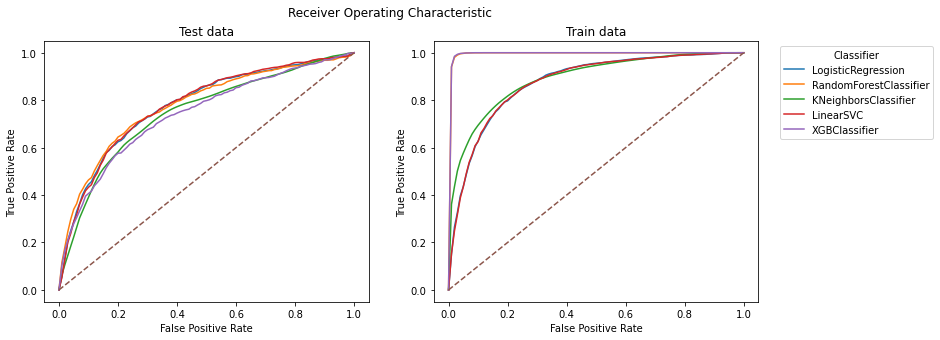

,test_f1,test_geometric_mean,test_roc_auc,train_f1,train_geometric_mean,train_roc_auc,clf,test_mean,train_mean
0,0.510152,0.713744,0.776846,0.610667,0.799491,0.875657,LogisticRegression,0.666914,0.761938
1,0.505961,0.664934,0.779162,0.928082,0.978728,0.997633,RandomForestClassifier,0.650019,0.968147
2,0.417530,0.625717,0.745915,0.495659,0.714881,0.891589,KNeighborsClassifier,0.596388,0.700709
3,0.510500,0.713232,0.778047,0.614760,0.801176,0.875313,LinearSVC,0.667260,0.763750
4,0.465625,0.649744,0.741269,0.936351,0.981673,0.997797,XGBClassifier,0.618879,0.971940


In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))

scores = []
for model_name in classifiers:
    clf = get_model_by_name(model_name)
    model_scores = kFold_pipeline(X, y, clf, transformer, axis=ax)
    model_scores.append(model_name)
    scores.append(model_scores)

test_metrics = ['test_f1', 'test_geometric_mean', 'test_roc_auc']
train_metrics = ['train_f1', 'train_geometric_mean', 'train_roc_auc']
columns = test_metrics + train_metrics + ['clf']

scores = pd.DataFrame(scores, columns=columns)
scores['test_mean'] = scores[test_metrics].mean(axis=1)
scores['train_mean'] = scores[train_metrics].mean(axis=1)

# Labels and legend
ax[0].set(title='Test data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[0].plot([0,1], [0,1], linestyle='--')
ax[1].set(title='Train data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[1].plot([0,1], [0,1], linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Classifier', bbox_to_anchor=(1.05, 1))
plt.suptitle('Receiver Operating Characteristic')
plt.savefig('roc_curve_pca.png', bbox_inches='tight', dpi=250)
plt.show()

scores

In [19]:
print(scores[['clf','test_f1','test_geometric_mean','test_roc_auc','test_mean']].to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
                    clf &  test\_f1 &  test\_geometric\_mean &  test\_roc\_auc &  test\_mean \\
\midrule
     LogisticRegression &     0.51 &                 0.71 &          0.78 &       0.67 \\
 RandomForestClassifier &     0.51 &                 0.66 &          0.78 &       0.65 \\
   KNeighborsClassifier &     0.42 &                 0.63 &          0.75 &       0.60 \\
              LinearSVC &     0.51 &                 0.71 &          0.78 &       0.67 \\
          XGBClassifier &     0.47 &                 0.65 &          0.74 &       0.62 \\
\bottomrule
\end{tabular}



In [20]:
print(scores[['clf','train_f1','train_geometric_mean','train_roc_auc','train_mean']].to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
                    clf &  train\_f1 &  train\_geometric\_mean &  train\_roc\_auc &  train\_mean \\
\midrule
     LogisticRegression &      0.61 &                  0.80 &           0.88 &        0.76 \\
 RandomForestClassifier &      0.93 &                  0.98 &           1.00 &        0.97 \\
   KNeighborsClassifier &      0.50 &                  0.71 &           0.89 &        0.70 \\
              LinearSVC &      0.61 &                  0.80 &           0.88 &        0.76 \\
          XGBClassifier &      0.94 &                  0.98 &           1.00 &        0.97 \\
\bottomrule
\end{tabular}



<a id='validation'></a>
# Validation

In [21]:
y_val = validation_pca['activity']
X_val = validation_pca[features]

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

Y = pd.DataFrame(validation_pca['CID'])
probas = pd.DataFrame(validation_pca['CID'])

for model_name in classifiers:
    clf = get_model_by_name(model_name)
    pipe = make_pipeline(SMOTE(random_state=42), transformer, clf)
    pipe.fit(X, y)
    
    y_pred = pipe.predict(X_val)
    Y[model_name] = y_pred
    
    y_proba = pipe.predict_proba(X_val)
    probas[model_name] = y_proba[:,1]

<a id='confusion'></a>
## Confusion matrices

In [23]:
def print_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix  
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    matrix = pd.DataFrame(conf_matrix)
    print(matrix.round(2))

In [24]:
for model_name in classifiers:
    print('\n', model_name)
    print_confusion_matrix(y_val, Y[model_name])
    
# TN FN
# FP TP


 LogisticRegression
      0     1
0  0.72  0.28
1  0.39  0.61

 RandomForestClassifier
      0     1
0  0.87  0.13
1  0.44  0.56

 KNeighborsClassifier
      0     1
0  0.52  0.48
1  0.17  0.83

 LinearSVC
      0     1
0  0.73  0.27
1  0.39  0.61

 XGBClassifier
      0     1
0  0.88  0.12
1  0.36  0.64


<a id='roc_val'></a>
## ROC

Classifier          	AUC	F1 	G-Mean
LogisticRegression  	0.75	0.51	0.66
RandomForestClassifier	0.79	0.58	0.70
KNeighborsClassifier	0.77	0.52	0.66
LinearSVC           	0.75	0.51	0.67
XGBClassifier       	0.77	0.65	0.75


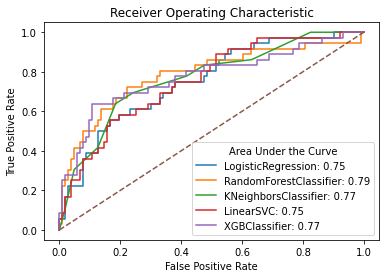

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from imblearn.metrics import geometric_mean_score

print('{:20s}\t{:3s}\t{:3s}\t{:3s}'.format('Classifier', 'AUC', 'F1', 'G-Mean'))

for model_name in classifiers:
    y_proba = probas[model_name]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name}: {auc_score:>.2f}')
    
    f1 = f1_score(y_val, Y[model_name])
    geometric_mean = geometric_mean_score(y_val, Y[model_name])
    print(f'{model_name:20s}\t{auc_score:.2f}\t{f1:.2f}\t{geometric_mean:.2f}')

plt.plot([0,1], [0,1], linestyle='--')
plt.legend(title='Area Under the Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.savefig('roc_curve_all_descriptors_validation.png', dpi=200)
plt.show()

<a id='error'></a>
## Error metrics

In [26]:
def error_metrics(y_true, y_proba):
    import numpy as np
    from sklearn.metrics import log_loss
    
    rmse = np.linalg.norm(y_proba - y_true) / np.sqrt(len(y_true))
    logl = log_loss(y_true, y_proba)
    return rmse, logl

In [27]:
error = []
for model_name in classifiers:
    rmse, logl = error_metrics(y_val, probas[model_name])
    error.append([model_name, rmse, logl])

error = pd.DataFrame(error, columns=['clf', 'rmse', 'log_loss'])
error

,clf,rmse,log_loss
0,LogisticRegression,0.453517,0.622907
1,RandomForestClassifier,0.406550,0.512385
2,KNeighborsClassifier,0.506398,1.176389
3,LinearSVC,0.441868,0.575752
4,XGBClassifier,0.401860,0.499480


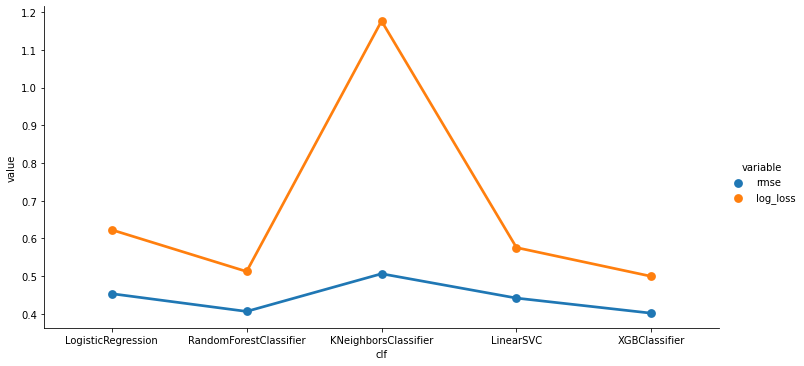

In [28]:
melt = pd.melt(error, id_vars='clf', value_vars=['rmse', 'log_loss'])
sns.catplot(kind='point', data=melt, x='clf', y='value', hue='variable', aspect=2)

<a id='spearman'></a>
## Spearman correlation

In [29]:
from scipy.stats import spearmanr

activity = pd.read_csv('../activity_data.csv')
docking = pd.read_csv('../docking.csv')
docking_list = docking.columns.tolist()[1:]

df = pd.merge(activity[['CID', 'f_inhibition_at_50_uM']], docking, on=['CID'])
df = pd.merge(df, probas, on=['CID'])

In [30]:
melt = pd.melt(df, id_vars=['CID','f_inhibition_at_50_uM'], value_vars=docking_list+classifiers)

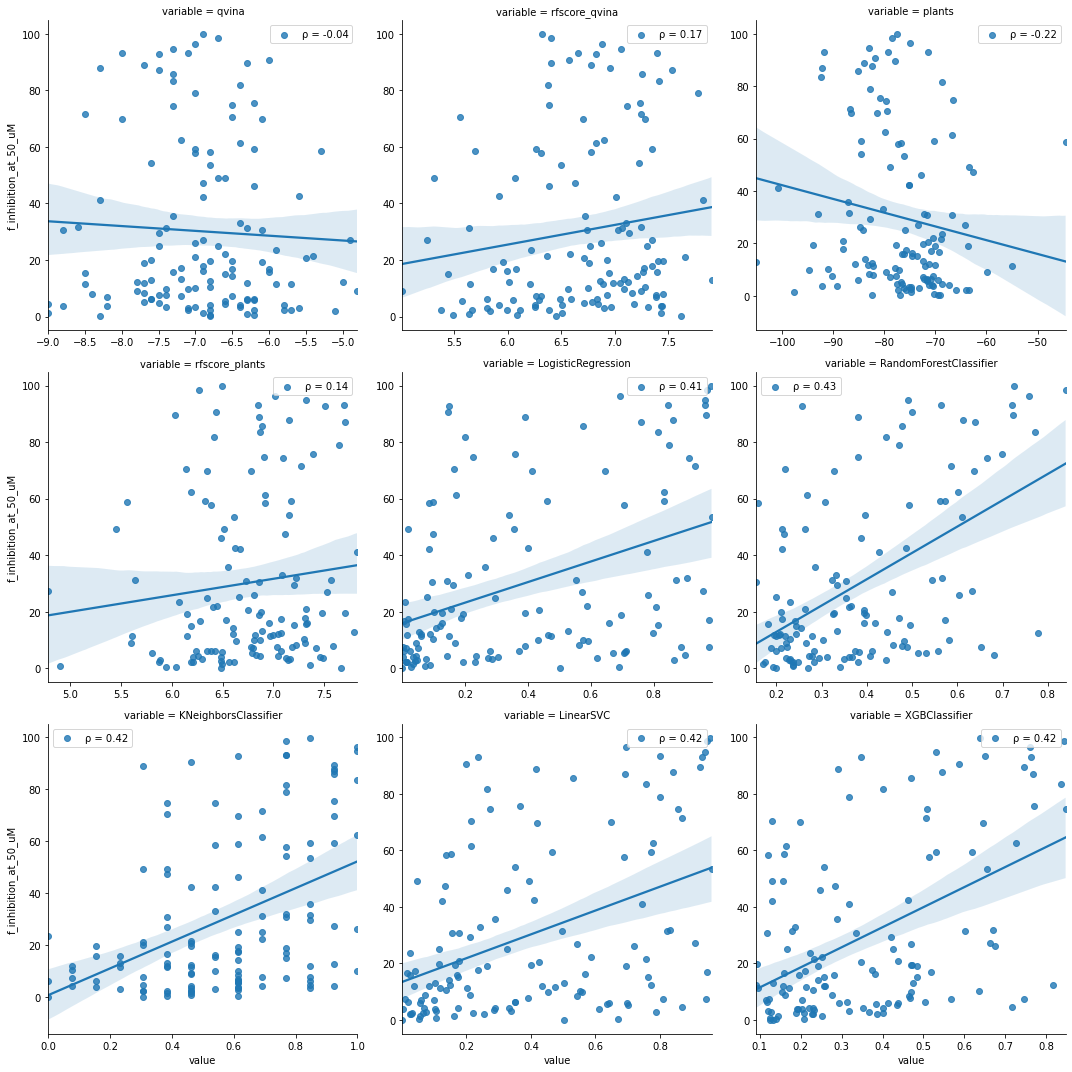

In [31]:
spearman = []

g = sns.lmplot(data=melt, x='value', y='f_inhibition_at_50_uM', col='variable', sharey=False, sharex=False, col_wrap=3)
for ax, col in zip(g.axes.flatten(), g.col_names):
    r, pvalue = spearmanr(df['f_inhibition_at_50_uM'], df[col])
    spearman.append([col, r, pvalue])
    ax.collections[0].set_label(f'ρ = {r:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

In [32]:
spearman = pd.DataFrame(spearman, columns=['SF', 'spearman_r', 'p_value'])
spearman

,SF,spearman_r,p_value
0,qvina,-0.042757,6.304320e-01
1,rfscore_qvina,0.170779,5.298532e-02
2,plants,-0.224402,1.057008e-02
3,rfscore_plants,0.143074,1.057662e-01
4,LogisticRegression,0.411879,1.237393e-06
5,RandomForestClassifier,0.433380,2.895875e-07
6,KNeighborsClassifier,0.416647,9.044784e-07
7,LinearSVC,0.417174,8.734397e-07
8,XGBClassifier,0.422708,6.029814e-07


<a id='distribution'></a>
## Distribution of the data

In [33]:
def percentage_dist(values):
    values = pd.Series(values, name='values')
    distribution = values.value_counts(
        normalize=True).mul(100).reset_index().rename({'values':'Percentage','index':'Class'}, axis=1)
    return distribution

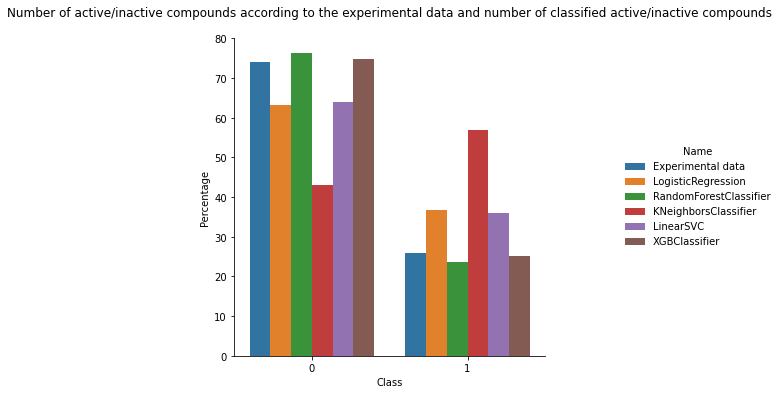

In [34]:
perc = percentage_dist(y_val)
perc['Name'] = 'Experimental data'

for model_name in classifiers:
    y_pred = Y[model_name]
    dist = percentage_dist(y_pred)
    dist['Name'] = model_name
    perc = perc.append(dist)

sns.catplot(kind='bar', data=perc, x='Class', y='Percentage', hue='Name')
plt.title('Number of active/inactive compounds according to the experimental data and number of classified active/inactive compounds', y=1.05)
plt.show()

Text(0.5, 1.0, 'Number of missed actives')

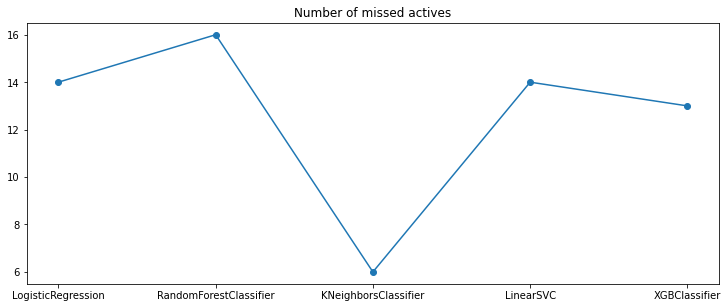

In [35]:
Y['experimental'] = y_val
count = [Y.query(f'{model_name} == 0 and experimental == 1').count().values[0] for model_name in classifiers]
plt.figure(figsize=(12.4, 4.8))
plt.plot(classifiers, count, marker='o')
plt.title('Number of missed actives')